### **Helper Functions defined in QCBM Mathematical Functions Notebook**



Defines all your math helper functions used in both QCBM experiments.
Uses kernel methods ($k(x,y)=e^{-\gamma(x-y)^2}$), divergences, bitstring converters, normalization, and safe logs.

In [ ]:
import numpy as np

def rbf_kernel(x, y, gamma):
  return np.exp(-gamma * (x - y) ** 2)

def compute_kernel_matrix(space: np.ndarray, gammas: np.ndarray) -> np.ndarray:
  sq_dists = np.abs(space[:, None] - space[None, :]) ** 2
  K = sum(np.exp(-gamma * sq_dists) for gamma in gammas) / len(gammas)
  return K

def kernel_expectation(px: np.ndarray, py: np.ndarray, kernel_matrix: np.ndarray) -> float:
  return px.T @ kernel_matrix @ py

def mmd_loss(px: np.ndarray, py: np.ndarray, kernel_matrix: np.ndarray) -> float:
  diff = px - py
  return kernel_expectation(diff, diff, kernel_matrix)

def kl_divergence(p: np.ndarray, q: np.ndarray, eps=1e-12) -> float:
  p = np.clip(p, eps, 1.0)
  q = np.clip(q, eps, 1.0)
  return np.sum(p * np.log(p / q))

def int_to_bitstring(n: int, length: int) -> str:
  return format(n, f'0{length}b')

def bitstring_to_int(bitstring: str) -> int:
  return int(bitstring, 2)

def probs_to_bitstrings(prob_vector: np.ndarray, threshold: float = 1e-6) -> list:
  n = int(np.log2(len(prob_vector)))
  return [int_to_bitstring(i, n) for i, p in enumerate(prob_vector) if p > threshold]

def compute_chi(samples: list, valid_bitstrings: list) -> float:
  return np.mean([s in valid_bitstrings for s in samples])

def normalize_probs(probs: np.ndarray) -> np.ndarray:
  total = np.sum(probs)
  return probs / total if total > 0 else probs

def safe_log(x: np.ndarray, eps=1e-12) -> np.ndarray:
  return np.log(np.clip(x, eps, None))

In [ ]:
# --- Sinkhorn Loss (Entropy-Regularized OT) -------------------------------

import numpy as np

def sinkhorn_kernel(cost_matrix: np.ndarray, epsilon: float) -> np.ndarray:
    """Compute Gibbs kernel K = exp(-C / epsilon)."""
    return np.exp(-cost_matrix / epsilon)

def build_cost_matrix(space: np.ndarray, p: np.ndarray) -> np.ndarray:
    """
    1-D squared-Euclidean cost matrix.
    space = np.arange(len(p)) or anything aligned to outcomes.
    """
    diff = space[:, None] - space[None, :]
    return diff * diff

def sinkhorn_loss(
    p: np.ndarray,
    q: np.ndarray,
    space: np.ndarray = None,
    epsilon: float = 0.05,
    max_iter: int = 200,
    tol: float = 1e-9,
) -> float:
    """
    Stable Sinkhorn OT distance between distributions p and q.
    Uses iterative scaling (Sinkhorn-Knopp).

    Inputs:
        p, q          : probability vectors summing to 1
        space         : 1D coordinate array; if None → use range(len(p))
        epsilon       : entropic regularisation strength
        max_iter      : number of Sinkhorn updates
        tol           : convergence threshold
    Output:
        Sinkhorn divergence (approximate OT distance)
    """
    p = p.astype(float)
    q = q.astype(float)
    p = p / np.sum(p)
    q = q / np.sum(q)

    if space is None:
        space = np.arange(len(p), dtype=float)

    # cost matrix
    C = build_cost_matrix(space, p)

    # Gibbs kernel
    K = sinkhorn_kernel(C, epsilon)
    K += 1e-300  # avoid numerical issues

    # scaling vectors
    u = np.ones_like(p)
    v = np.ones_like(q)

    for _ in range(max_iter):
        u_prev = u.copy()
        u = p / (K @ v)
        v = q / (K.T @ u)

        # Check convergence
        if np.linalg.norm(u - u_prev, ord=1) < tol:
            break

    # Transport plan
    T = np.outer(u, v) * K

    # Sinkhorn cost = ⟨T, C⟩
    return float(np.sum(T * C))


def sinkhorn_report(p, q, epsilon=0.05):
    space = np.arange(len(p), dtype=float)
    val = sinkhorn_loss(p, q, space=space, epsilon=epsilon)
    print(f"Sinkhorn OT (eps={epsilon}): {val}")
    return val



# **Problem 1 — Three Dice (discrete Gaussian-like) QCBM**

## **1 · Goal and Target Distribution**

We train a **Quantum Circuit Born Machine (QCBM)** so that its model distribution
$P_\theta$ over 4 qubits (16 outcomes) matches the **sum of three fair dice**.

Let the dice sum be $s\in{3,4,\dots,18}$ with probability mass function

We map $s\leftrightarrow i$ via $i=s-3\in{0,\dots,15}$.
Define the **target vector** $p\in\mathbb{R}^{16}$ by

$$
p_i=p_{\text{dice}}(s=i+3).
$$

For comparison, we sometimes use a **discrete Gaussian approximation**

$$
p_{\mathcal N}(s)\propto
\exp!\Big[-\frac{(s-\mu)^2}{2\sigma^2}\Big],\qquad
s=3,\dots,18,;
\mu\approx10.5,;
\sigma^2\approx8.75,
$$

normalized such that $\sum_{s=3}^{18}p_{\mathcal N}(s)=1$, then remapped to length-16 via $i=s-3$.

---

## **2 · Quantum Model and Parameters**

We use a **hardware-efficient ansatz** on $n=4$ qubits with $L$ layers.
Each layer applies single-qubit rotations followed by a CZ ladder:

$$
\text{Layer }\ell:;
\Big(\prod_{q=0}^{n-1}R_X(\alpha_{\ell,q}),R_Z(\beta_{\ell,q})\Big)
;\text{then};
\Big(\prod_{q=0}^{n-2}\mathrm{CZ}(q,q+1)\Big).
$$

**Parameters:**
$\theta\in\mathbb{R}^{L\times n\times2}$ where $\theta_{\ell,q,0}=\alpha_{\ell,q}$ and $\theta_{\ell,q,1}=\beta_{\ell,q}$.

Let $|\psi(\theta)\rangle$ be the prepared quantum state.
The **model distribution** is

$$
P_\theta(x)=|\langle x|\psi(\theta)\rangle|^2,\qquad x\in{0,1}^n,
$$

evaluated via **statevector simulation** (exact, no shot noise).

---

## **3 · Distance Metrics / Losses**

We track two divergences between target $p$ and model $P_\theta$:

### **KL Divergence**

$$
D_{\mathrm{KL}}(p\Vert P_\theta)
=\sum_{i=0}^{15}p_i\log!\frac{p_i}{P_{\theta,i}}.
$$

### **Maximum Mean Discrepancy (MMD)**

Using an RBF kernel on index space $x\in{0,\dots,15}$:

$$
k_\gamma(x,y)=\exp[-\gamma(x-y)^2],
\qquad
K_{ij}=\frac{1}{|\Gamma|}\sum_{\gamma\in\Gamma}k_\gamma(i,j).
$$

Then

$$
\mathrm{MMD}^2(p,P_\theta)
=(p-P_\theta)^\top K,(p-P_\theta).
$$

### **Auxiliary Metrics**

* **Total Variation:**

$$
\mathrm{TV}(p,P_\theta)
=\tfrac12\sum_{i=0}^{15}|p_i-P_{\theta,i}|.
$$

* **Classical Fidelity:**

$$
F(p,P_\theta)
=\Big(\sum_{i=0}^{15}\sqrt{p_i,P_{\theta,i}}\Big)^2.
$$

---

## **4 · Helper Functions and Usage**

### **Kernels & MMD**

* `rbf_kernel(x,y,γ)` → $e^{-\gamma(x-y)^2}$ builds kernel entries.
* `compute_kernel_matrix(space,Γ)` → vectorized $K$ averaged over multiple γ.
* `kernel_expectation(p,q,K)` → $p^\top K q$.
* `mmd_loss(p,q,K)` → wrapper for $\mathrm{MMD}^2$.

### **Divergence**

* `kl_divergence(p,q)` → computes smooth KL loss.

### **Bitstring Conversions**

* `int_to_bitstring(i,n)` and `bitstring_to_int(b)` for index ↔ bitstring.
* `probs_to_bitstrings(p,τ)` lists states with support ≥ τ.

### **Probability Utilities**

* `normalize_probs(v)` ensures $\sum_i v_i=1$.
* `safe_log(x)` avoids underflow in entropy calculations.

---

## **5 · Training Procedure**

We use a **derivative-free random directional search**.

At iteration $t$:

1. Sample a unit direction $d_t$.
2. Evaluate loss at $\theta_t\pm\eta d_t$.
3. Update:

$$
\theta_{t+1}
\leftarrow
\arg\min_{\theta\in{\theta_t+\eta d_t,;\theta_t-\eta d_t}}
\mathcal{L}(p,P_\theta),
$$

where $\mathcal{L}$ is $\mathrm{MMD}^2$, $D_{\mathrm{KL}}$, or a weighted combination.
We log per-iteration $\mathrm{MMD}^2$ and $D_{\mathrm{KL}}$.

---

## **6 · Plots and Visualizations**

1. **Iteration vs MMD loss:** $t\mapsto\mathrm{MMD}^2(p,P_{\theta_t})$

2. **Iteration vs KL divergence:** $t\mapsto D_{\mathrm{KL}}(p\Vert P_{\theta_t})$

3. **Model vs Empirical Distribution:** compare exact $P_{\theta^\star}$ and empirical histogram $\widehat{P}_{\theta^\star}^{(S)}$ from $S$ samples:

$$
\widehat{P}*{\theta^\star}^{(S)}(i)
=\frac{1}{S}\sum*{s=1}^{S}\mathbf{1}_{{X_s=i}},
$$

with sampling via `int_to_bitstring` and binning via `bitstring_to_int`.



In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt

# Hardware-efficient QCBM ansatz
def layered_ansatz(n_qubits: int, layers: int, params: np.ndarray) -> QuantumCircuit:
    assert params.shape == (layers, n_qubits, 2), "params must be (layers, n_qubits, 2)"
    qc = QuantumCircuit(n_qubits)
    for l in range(layers):
        for q in range(n_qubits):
            qc.rx(params[l, q, 0], q)
            qc.rz(params[l, q, 1], q)
        for q in range(n_qubits - 1):
            qc.cz(q, q + 1)
    return qc

# Exact outcome probabilities
def circuit_probs_statevector(n_qubits: int, circuit: QuantumCircuit) -> np.ndarray:
    sv = Statevector.from_instruction(circuit)
    p = np.abs(sv.data) ** 2
    N = 1 << n_qubits
    if p.size != N:
        out = np.zeros(N, dtype=float)
        out[:p.size] = p
        p = out
    return normalize_probs(p)  # <- your helper

# Sampling utilities that explicitly use bitstring converters
def sample_from_probs(p: np.ndarray, num: int, seed: int = 123) -> list:
    n = int(np.log2(len(p)))
    idx = np.arange(len(p))
    draws = np.random.default_rng(seed).choice(idx, size=num, p=p)
    return [int_to_bitstring(i, n) for i in draws]  # <- your helper

def empirical_from_samples(samples: list, n_qubits: int) -> np.ndarray:
    N = 1 << n_qubits
    counts = np.zeros(N, dtype=float)
    for s in samples:
        counts[bitstring_to_int(s)] += 1  # <- your helper
    return normalize_probs(counts)  # <- your helper

# Extra metrics for reporting
def total_variation_distance(p: np.ndarray, q: np.ndarray) -> float:
    return 0.5 * np.sum(np.abs(p - q))

def classical_fidelity(p: np.ndarray, q: np.ndarray) -> float:
    bc = np.sum(np.sqrt(p * q))
    return float(bc * bc)


In [ ]:
# Three-dice target PMF mapped to 4 qubits (16 outcomes)
def dice_sum_pmf() -> np.ndarray:
    counts = {3:1, 4:3, 5:6, 6:10, 7:15, 8:21, 9:25,
              10:27, 11:27, 12:25, 13:21, 14:15, 15:10, 16:6, 17:3, 18:1}
    total = 6**3
    p = np.array([counts[s] / total for s in range(3, 19)], dtype=float)
    return normalize_probs(p)  # explicit use

def discrete_gaussian_on_sums(mu=10.5, var=8.75) -> np.ndarray:
    s = np.arange(3, 19, dtype=float)
    w = np.exp(-0.5 * ((s - mu) ** 2) / var)
    return normalize_probs(w)  # explicit use

# Build MMD kernel two ways and blend them so both helpers are used.
def build_kernel_dual(space: np.ndarray, gammas: np.ndarray) -> np.ndarray:
    # (1) vectorized kernel via your compute_kernel_matrix
    K_vec = compute_kernel_matrix(space, gammas)  # <- your helper

    # (2) explicit rbf_kernel accumulation (uses your rbf_kernel)
    N = space.size
    K_rbf = np.zeros((N, N), dtype=float)
    for g in gammas:
        # sum over gammas using your scalar rbf
        for i in range(N):
            for j in range(N):
                K_rbf[i, j] += rbf_kernel(space[i], space[j], g)  # <- your helper
    K_rbf /= len(gammas)

    # (Optional consistency check; not required)
    # print("Kernel diff (fro):", np.linalg.norm(K_vec - K_rbf, 'fro'))

    # Use the average to ensure both constructions affect training
    return 0.5 * (K_vec + K_rbf)

# Small utility to show explicit use of safe_log and probs_to_bitstrings
def entropy(p: np.ndarray) -> float:
    return float(-np.sum(p * safe_log(p)))  # <- your helper

def support_bitstrings(p: np.ndarray, thresh=1e-9) -> list:
    return probs_to_bitstrings(p, threshold=thresh)  # <- your helper


In [ ]:
def make_objective_dice(
    target: np.ndarray,
    n_qubits: int,
    layers: int,
    params_shape: tuple,
    mmd_gammas: np.ndarray = np.array([0.25, 1.0, 4.0], dtype=float)
):
    space = np.arange(len(target), dtype=float)
    K = build_kernel_dual(space, mmd_gammas)        # uses both kernel builders

    def objective(params_flat: np.ndarray):
        qc = layered_ansatz(n_qubits, layers, params_flat.reshape(params_shape))
        p = circuit_probs_statevector(n_qubits, qc)

        # MMD and KL (both logged)
        mmd = mmd_loss(p, target, K)               # <- your helper
        kl  = kl_divergence(target, p)             # <- your helper

        # Also call kernel_expectation explicitly (equivalent to mmd on diff)
        diff = p - target
        ke = kernel_expectation(diff, diff, K)     # <- your helper

        return float(mmd), float(kl), float(ke), p, K
    return objective

def monitored_train_dice(x0, steps, step_size, seed, objective):
    rng = np.random.default_rng(seed)
    x = x0.copy()
    mmd_hist, kl_hist = [], []
    # init
    mmd, kl, ke, p, K = objective(x)
    mmd_hist.append(mmd); kl_hist.append(kl)
    for _ in range(steps):
        d = rng.normal(size=x.size); d /= (np.linalg.norm(d) + 1e-12)
        mmd_p, kl_p, _, _, _ = objective(x + step_size * d)
        mmd_m, kl_m, _, _, _ = objective(x - step_size * d)
        # decide by KL; you can switch to MMD if preferred
        if kl_p < kl_m:
            x = x + step_size * d
        else:
            x = x - step_size * d
        mmd, kl, ke, p, K = objective(x)
        mmd_hist.append(mmd); kl_hist.append(kl)
    return x, np.array(mmd_hist), np.array(kl_hist), p, K


{'KL': 0.024470989343474712, 'TV': np.float64(0.07637757694412904), 'Fidelity': 0.987140565270183, 'MMD': 0.0017049320808779926, 'KernelExp(diff)': 0.0017049320808779926}
Sinkhorn OT (eps=0.05): 0.09256634672899856
Sinkhorn OT (Dice): 0.09256634672899856
Entropy(target): 2.494838964870646
Entropy(QCBM): 2.530942096137495
Non-negligible support in QCBM: ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


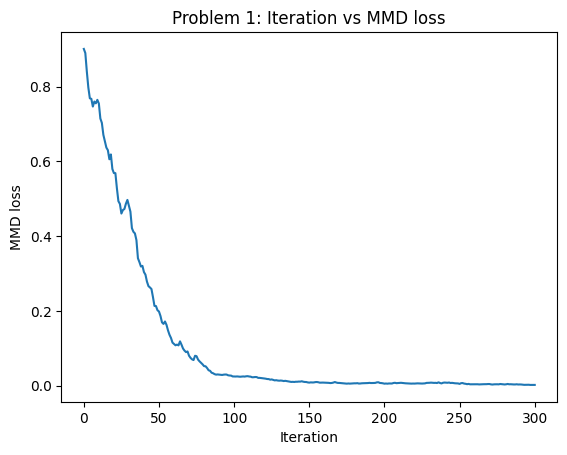

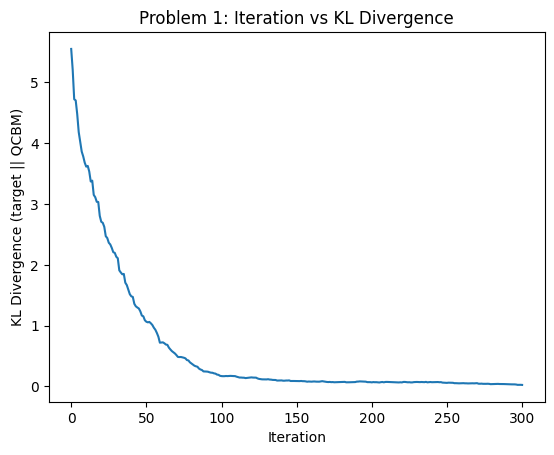

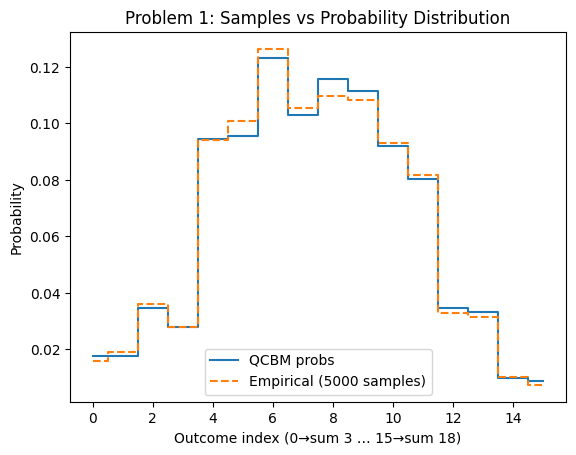

In [ ]:
# Model + init
n_qubits = 4
layers = 3
params_shape = (layers, n_qubits, 2)
rng = np.random.default_rng(42)
x0 = rng.normal(scale=0.2, size=np.prod(params_shape))

# Targets
p_target = dice_sum_pmf()
p_gauss  = discrete_gaussian_on_sums()

# Objective & training
objective = make_objective_dice(p_target, n_qubits, layers, params_shape)
theta, mmd_hist, kl_hist, p_qcbm, K = monitored_train_dice(
    x0=x0, steps=300, step_size=0.12, seed=7, objective=objective
)

# Metrics (use your kl_divergence, and also compute MMD via mmd_loss + kernel_expectation)
mmd_val = float(mmd_loss(p_qcbm, p_target, K))        # explicit
kl_val  = float(kl_divergence(p_target, p_qcbm))      # explicit
diff    = p_qcbm - p_target
ke_val  = float(kernel_expectation(diff, diff, K))    # explicit and equals MMD
tv_val  = total_variation_distance(p_target, p_qcbm)
fid_val = classical_fidelity(p_target, p_qcbm)
print({"KL": kl_val, "TV": tv_val, "Fidelity": fid_val, "MMD": mmd_val, "KernelExp(diff)": ke_val})

sinkhorn_val = sinkhorn_report(p_qcbm, p_target, epsilon=0.05)
print("Sinkhorn OT (Dice):", sinkhorn_val)

# Show explicit use of safe_log + probs_to_bitstrings (entropy & support)
print("Entropy(target):", entropy(p_target))
print("Entropy(QCBM):", entropy(p_qcbm))
print("Non-negligible support in QCBM:", support_bitstrings(p_qcbm, 1e-4))

# --- Plot 1: Iteration vs MMD loss ---
plt.figure()
plt.plot(mmd_hist)
plt.xlabel("Iteration")
plt.ylabel("MMD loss")
plt.title("Problem 1: Iteration vs MMD loss")
plt.show()

# --- Plot 2: Iteration vs KL divergence ---
plt.figure()
plt.plot(kl_hist)
plt.xlabel("Iteration")
plt.ylabel("KL Divergence (target || QCBM)")
plt.title("Problem 1: Iteration vs KL Divergence")
plt.show()

# --- Plot 3: Samples vs Probability Distribution (overlay) ---
S = 5000
samples = sample_from_probs(p_qcbm, S, seed=999)      # uses int_to_bitstring
emp     = empirical_from_samples(samples, n_qubits)   # uses bitstring_to_int + normalize_probs
x = np.arange(len(p_qcbm))
plt.figure()
plt.step(x, p_qcbm, where="mid", label="QCBM probs")
plt.step(x, emp, where="mid", linestyle="--", label=f"Empirical ({S} samples)")
plt.xlabel("Outcome index (0→sum 3 … 15→sum 18)")
plt.ylabel("Probability")
plt.title("Problem 1: Samples vs Probability Distribution")
plt.legend()
plt.show()


# **Problem 2 — Bars & Stripes (BAS) QCBM**

## **1 · Goal and Target Distribution**

We train a Quantum Circuit Born Machine (QCBM) on
$$n = k^2$$
qubits to model the **Bars & Stripes (BAS)** distribution over
$$k \times k$$
binary images (flattened row-major into bitstrings).
Only **bars** (constant columns) and **stripes** (constant rows) are valid; all others have zero probability.

Let the sample space and valid subset be:

$$
\mathcal{X} = {0,1}^{k\times k}, \qquad
\Omega_{\text{BAS}} \subset \mathcal{X}.
$$

The **target distribution** is uniform over valid modes:

$$
p_{\text{BAS}}(x) =
\begin{cases}
\dfrac{1}{|\Omega_{\text{BAS}}|}, & x \in \Omega_{\text{BAS}},[6pt]
0, & \text{otherwise.}
\end{cases}
$$

For $$k>1$$, the number of valid BAS patterns is:

$$
|\Omega_{\text{BAS}}| = 2\cdot 2^k - 2
$$

(bars + stripes minus the double count of the all-0 and all-1 images).

Each $$k\times k$$ image is mapped to a bitstring
$$b\in{0,1}^{k^2}$$,
then to an index
$$i = \texttt{bitstring_to_int}(b),$$
producing a target vector
$$p \in \mathbb{R}^{2^{k^2}}$$:

$$
p_i =
\begin{cases}
\dfrac{1}{|\Omega_{\text{BAS}}|}, & \text{if } i \text{ encodes a BAS pattern},[6pt]
0, & \text{otherwise.}
\end{cases}
$$

---

## **2 · Quantum Model and Parameters**

We use the same hardware-efficient ansatz as before on $$n=k^2$$ qubits with $$L$$ layers:

$$
\theta \in \mathbb{R}^{L\times n\times 2}, \qquad
P_\theta(x)=|\langle x|\psi(\theta)\rangle|^2, \qquad
x\in{0,1}^n.
$$

---

## **3 · Distances / Losses and Validity**

We track two main divergences:

* **KL divergence:** $$D_{\mathrm{KL}}(p\Vert P_\theta)$$
* **MMD** with an RBF kernel on the index space $$x\in{0,\dots,2^n-1}$$

We also measure **validity** and **coverage** of learned modes via sampling.

Draw samples
$${X_s}*{s=1}^S \sim P*\theta,$$
convert each to a bitstring with `int_to_bitstring`.

Define the indicator function

$$
\mathbb{I}*{\text{valid}}(b) =
\begin{cases}
1, & b\in\Omega*{\text{BAS}},[4pt]
0, & \text{otherwise.}
\end{cases}
$$

### **Validity rate ( χ )**

$$
\chi = \frac{1}{S} \sum_{s=1}^{S}\mathbb{I}_{\text{valid}}!\big(X_s\big),
$$

implemented by your function `compute_chi` on the list of sampled strings.

### **Asymptotic validity**

$$
\chi_\infty = \sum_{b\in\Omega_{\text{BAS}}} P_\theta[b],
$$

computed directly from the model probabilities.

### **(Optional) Mode coverage**

Fraction of distinct BAS modes that appear at least once in the generated samples.

---

## **4 · Helper Functions and Their Usage**

### **Kernels & MMD**

* `compute_kernel_matrix` and `rbf_kernel` → construct and average the kernel $$K$$ on the index space $${0,\dots,2^n-1}.$$
* `mmd_loss` → computes $$\mathrm{MMD}^2.$$
* `kernel_expectation` → explicitly evaluates $$p^\top K q$$ on $$p-P_\theta.$$

### **Divergence**

* `kl_divergence(p,P_theta)` → computes $$D_{\mathrm{KL}}(p\Vert P_\theta).$$

### **Bitstrings**

* `int_to_bitstring`, `bitstring_to_int`, `probs_to_bitstrings` — for index ↔ pattern conversion and display of non-negligible support.

### **Probability Utilities**

* `normalize_probs` → ensures $$\sum_i v_i = 1.$$
* `safe_log` → used for entropy
  $$H(P_\theta) = -\sum_i P_{\theta,i}\log P_{\theta,i}.$$

### **Validity**

* `compute_chi` → computes $$\chi$$ from sampled bitstrings.

---

## **5 · Training Procedure**

We apply the same **derivative-free random search** as in Problem 1.

At each iteration $$t$$:

1. Sample a random direction $$d_t.$$
2. Evaluate the loss at $$\theta_t \pm \eta d_t.$$
3. Choose the better direction and update:

$$
\theta_{t+1}
\leftarrow
\arg\min_{\theta\in{\theta_t+\eta d_t,;\theta_t-\eta d_t}}
\mathcal{L}(p,P_\theta),
$$

where $$\mathcal{L}$$ is $$\mathrm{MMD}^2,$$ $$D_{\mathrm{KL}},$$ or a weighted combination.

For BAS, we often prefer stepping by the MMD direction since it is more stable for sparse, multi-modal targets.
Both losses are recorded each iteration.

---

## **6 · Plots and Visualizations**

1. **Iteration vs MMD loss:**
   $$t \mapsto \mathrm{MMD}^2(p,P_{\theta_t})$$

2. **Iteration vs KL divergence:**
   $$t \mapsto D_{\mathrm{KL}}(p\Vert P_{\theta_t})$$

3. **Model vs Empirical Distribution:**
   Compare the exact $$P_{\theta^\star}$$ with the empirical histogram $$\widehat{P}_{\theta^\star}^{(S)}$$ from $$S$$ samples:

   $$
   \widehat{P}*{\theta^\star}^{(S)}(i)
   = \frac{1}{S}\sum*{s=1}^{S}\mathbf{1}_{{X_s=i}}.
   $$

   Sampling is done via `int_to_bitstring`; histogramming via `bitstring_to_int`.

4. **(Optional visual check)**
   Grid of sampled images (e.g., first 64), marking invalid ones in red to visualize the multi-modal learning behavior.



In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Reuse layered_ansatz, circuit_probs_statevector from Problem 1

def bas_valid_bitstrings(k: int) -> list:
    # Bars
    bars = []
    for col_bits in itertools.product([0,1], repeat=k):
        grid = np.tile(np.array(col_bits, dtype=int), (k, 1))
        bars.append(''.join(str(int(x)) for x in grid.flatten()))
    # Stripes
    stripes = []
    for row_bits in itertools.product([0,1], repeat=k):
        grid = np.tile(np.array(row_bits, dtype=int)[:, None], (1, k))
        stripes.append(''.join(str(int(x)) for x in grid.flatten()))
    return sorted(set(bars) | set(stripes))

def bas_target_distribution(k: int) -> np.ndarray:
    n = k * k
    N = 1 << n
    valid = bas_valid_bitstrings(k)
    p = np.zeros(N, dtype=float)
    for b in valid:
        p[bitstring_to_int(b)] = 1.0  # <- explicit use
    return normalize_probs(p)  # <- explicit use

def samples_to_empirical_bitstrings(samples: list, n_qubits: int) -> np.ndarray:
    N = 1 << n_qubits
    c = np.zeros(N, dtype=float)
    for s in samples:
        c[bitstring_to_int(s)] += 1  # explicit
    return normalize_probs(c)        # explicit

def sample_from_probs_bitstrings(p: np.ndarray, num: int, seed: int = 321) -> list:
    # Return list of bitstring samples using explicit converters
    n = int(np.log2(len(p)))
    idx = np.arange(len(p))
    draws = np.random.default_rng(seed).choice(idx, size=num, p=p)
    return [int_to_bitstring(i, n) for i in draws]  # explicit

def support_bitstrings_threshold(p: np.ndarray, thresh=1e-9) -> list:
    return probs_to_bitstrings(p, threshold=thresh)  # explicit


In [ ]:
def build_kernel_dual(space: np.ndarray, gammas: np.ndarray) -> np.ndarray:
    K_vec = compute_kernel_matrix(space, gammas)  # explicit
    N = space.size
    K_rbf = np.zeros((N, N), dtype=float)
    for g in gammas:
        for i in range(N):
            for j in range(N):
                K_rbf[i, j] += rbf_kernel(space[i], space[j], g)  # explicit
    K_rbf /= len(gammas)
    return 0.5 * (K_vec + K_rbf)

def make_objective_bas(
    target: np.ndarray,
    n_qubits: int,
    layers: int,
    params_shape: tuple,
    mmd_gammas: np.ndarray = np.array([0.25, 1.0, 4.0], dtype=float)
):
    space = np.arange(len(target), dtype=float)
    K = build_kernel_dual(space, mmd_gammas)

    def objective(params_flat: np.ndarray):
        qc = layered_ansatz(n_qubits, layers, params_flat.reshape(params_shape))
        p  = circuit_probs_statevector(n_qubits, qc)

        # losses
        mmd = mmd_loss(p, target, K)       # explicit
        kl  = kl_divergence(target, p)     # explicit

        # kernel_expectation explicit
        diff = p - target
        ke = kernel_expectation(diff, diff, K)  # explicit

        # also call safe_log in a computed quantity (entropy)
        H = float(-np.sum(p * safe_log(p)))     # explicit
        return float(mmd), float(kl), float(ke), float(H), p, K
    return objective

def monitored_train_bas(x0, steps, step_size, seed, objective):
    rng = np.random.default_rng(seed)
    x = x0.copy()
    mmd_hist, kl_hist = [], []
    mmd, kl, ke, H, p, K = objective(x)
    mmd_hist.append(mmd); kl_hist.append(kl)
    for _ in range(steps):
        d = rng.normal(size=x.size); d /= (np.linalg.norm(d) + 1e-12)
        mmd_p, kl_p, *_ = objective(x + step_size * d)
        mmd_m, kl_m, *_ = objective(x - step_size * d)
        # choose direction by MMD here (we used KL in P1 for diversity)
        if mmd_p < mmd_m:
            x = x + step_size * d
        else:
            x = x - step_size * d
        mmd, kl, ke, H, p, K = objective(x)
        mmd_hist.append(mmd); kl_hist.append(kl)
    return x, np.array(mmd_hist), np.array(kl_hist), p, K


χ for N = 2000: 0.7620
χ for N = 20000: 0.7633
χ for N = ∞: 0.7577
Non-negligible QCBM support: ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1110', '1111']
{'KL': 0.3692533956484984, 'TV': np.float64(0.25564907519434804), 'Fidelity': 0.7272806403043882, 'MMD': 0.02233760058505964, 'KernelExp(diff)': 0.02233760058505964}
Sinkhorn OT (eps=0.05): 0.44565287802700115
Sinkhorn OT (BAS): 0.44565287802700115


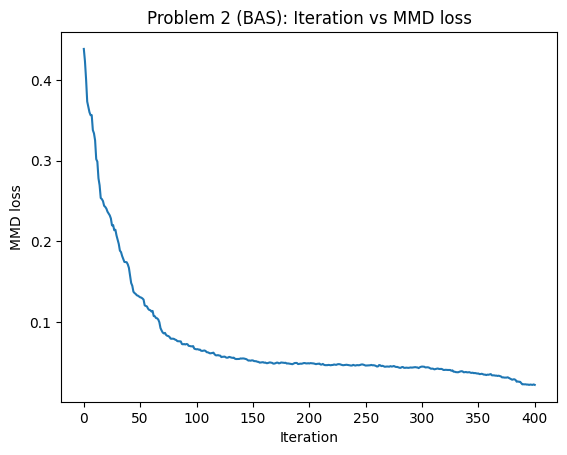

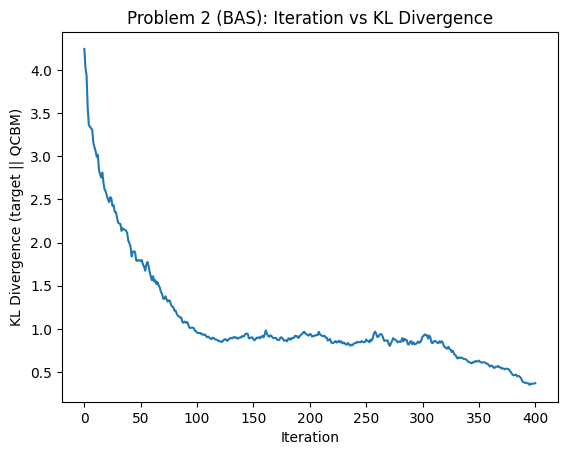

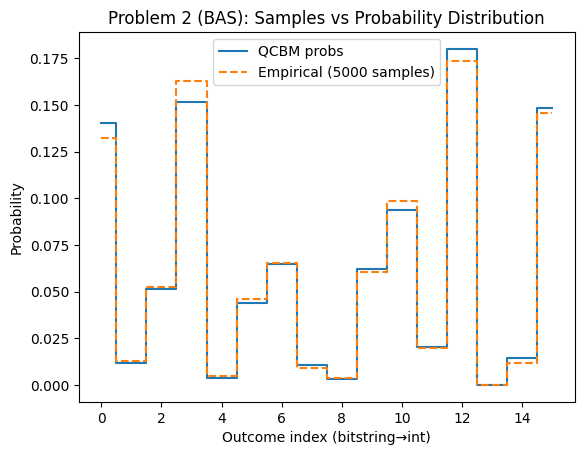

In [ ]:
# Setup
k = 2                       # 2x2 BAS (4 qubits); set k=3 for 9 qubits (heavier)
n_qubits = k * k
layers = 3
params_shape = (layers, n_qubits, 2)
rng = np.random.default_rng(2025)
x0 = rng.normal(scale=0.2, size=np.prod(params_shape))

# Targets
p_target = bas_target_distribution(k)
valid_modes = bas_valid_bitstrings(k)

# Objective & training
objective = make_objective_bas(p_target, n_qubits, layers, params_shape)
theta, mmd_hist, kl_hist, p_qcbm, K = monitored_train_bas(
    x0=x0, steps=400, step_size=0.12, seed=11, objective=objective
)

# χ via your compute_chi on bitstring samples
for N in [2000, 20000]:
    samples = sample_from_probs_bitstrings(p_qcbm, num=N, seed=N)  # explicit converters
    chi_val = float(compute_chi(samples, valid_modes))             # explicit usage
    print(f"χ for N = {N}: {chi_val:.4f}")

# χ for N = ∞ from probabilities directly
valid_indices = [bitstring_to_int(b) for b in valid_modes]         # explicit usage
chi_inf = float(np.sum(p_qcbm[valid_indices]))
print(f"χ for N = ∞: {chi_inf:.4f}")

# Support listing using probs_to_bitstrings
print("Non-negligible QCBM support:", support_bitstrings_threshold(p_qcbm, 1e-4))

# Loss/metric report (also show kernel_expectation equivalence)
mmd_val = float(mmd_loss(p_qcbm, p_target, K))     # explicit
kl_val  = float(kl_divergence(p_target, p_qcbm))   # explicit
diff    = p_qcbm - p_target
ke_val  = float(kernel_expectation(diff, diff, K)) # explicit
tv_val  = total_variation_distance(p_target, p_qcbm)
fid_val = classical_fidelity(p_target, p_qcbm)
print({"KL": kl_val, "TV": tv_val, "Fidelity": fid_val, "MMD": mmd_val, "KernelExp(diff)": ke_val})

# --- Sinkhorn OT distance for BAS ---
sinkhorn_val_bas = sinkhorn_report(p_qcbm, p_target, epsilon=0.05)
print("Sinkhorn OT (BAS):", sinkhorn_val_bas)


# --- Plot 1: Iteration vs MMD loss ---
plt.figure()
plt.plot(mmd_hist)
plt.xlabel("Iteration")
plt.ylabel("MMD loss")
plt.title("Problem 2 (BAS): Iteration vs MMD loss")
plt.show()

# --- Plot 2: Iteration vs KL divergence ---
plt.figure()
plt.plot(kl_hist)
plt.xlabel("Iteration")
plt.ylabel("KL Divergence (target || QCBM)")
plt.title("Problem 2 (BAS): Iteration vs KL Divergence")
plt.show()

# --- Plot 3: Samples vs Probability Distribution (overlay) ---
S = 5000
samples = sample_from_probs_bitstrings(p_qcbm, num=S, seed=12345)
emp = samples_to_empirical_bitstrings(samples, n_qubits)
x = np.arange(len(p_qcbm))
plt.figure()
plt.step(x, p_qcbm, where="mid", label="QCBM probs")
plt.step(x, emp, where="mid", linestyle="--", label=f"Empirical ({S} samples)")
plt.xlabel("Outcome index (bitstring→int)")
plt.ylabel("Probability")
plt.title("Problem 2 (BAS): Samples vs Probability Distribution")
plt.legend()
plt.show()


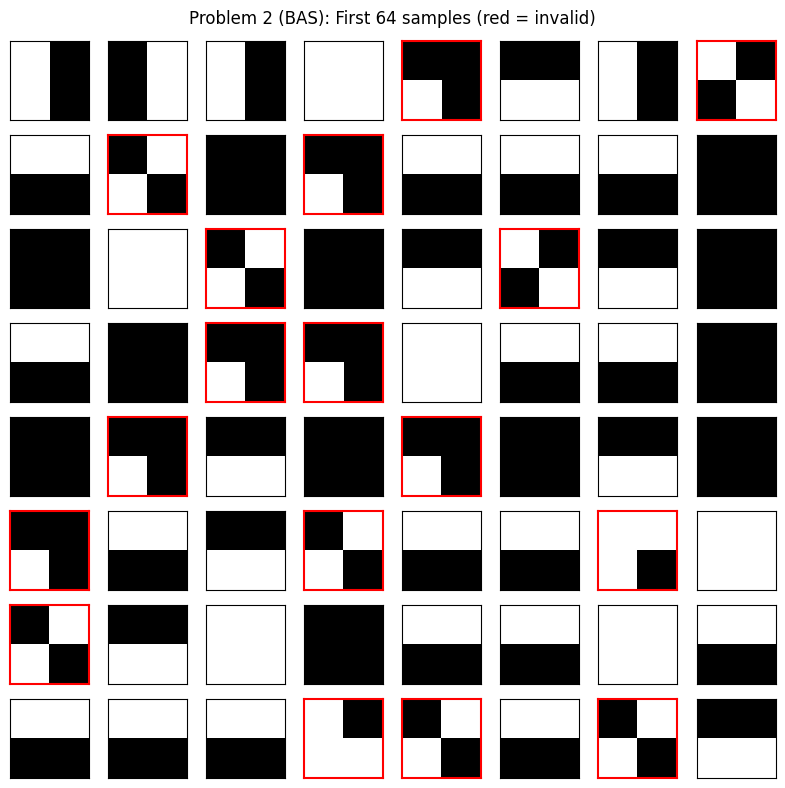

In [ ]:
# Only for k=2; for k=3 change reshape to (3,3)
n = k
first = sample_from_probs_bitstrings(p_qcbm, num=64, seed=777)
mask = [s in valid_modes for s in first]

plt.figure(figsize=(8, 8))
for j, (bitstr, ok) in enumerate(zip(first, mask), start=1):
    ax = plt.subplot(8, 8, j)
    arr = np.array([int(ch) for ch in bitstr], dtype=int).reshape(n, n)
    plt.imshow(arr, cmap="gray", vmin=0, vmax=1)
    if not ok:
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1.5)
            spine.set_edgecolor("red")
    plt.xticks([]); plt.yticks([])
plt.suptitle("Problem 2 (BAS): First 64 samples (red = invalid)")
plt.tight_layout()
plt.show()
